<a href="https://colab.research.google.com/github/pachterlab/BI-BE-CS-183-2023/blob/main/HW7/Problem3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Bi/Be/Cs 183 2022-2023: Intro to Computational Biology
TAs: Meichen Fang, Tara Chari, Zitong (Jerry) Wang

**Submit your notebooks by sharing a clickable link with Viewer access. Link must be accessible from submitted assignment document.**

Make sure Runtime $\rightarrow$ Restart and run all works without error

**HW 7 Problem 3**

In this problem you will be using various tests to look for differential expression between cells in different cell types. This will involve comparing means between different cell populations across genes, determining gene candidates with 'significant' differences in expression, and gauging how accurate or trustworthy such results are.


##**Import data and install packages**

In [3]:
import numpy as np
import scipy.io as sio
import pandas as pd
import matplotlib.pyplot as plt #Can use other plotting packages like seaborn

In [4]:
#Download count matrix of cell by gene counts and metadata files, DOI: 10.22002/D1.20031

import requests
from tqdm import tnrange, tqdm_notebook
def download_file(doi,ext):
    url = 'https://api.datacite.org/dois/'+doi+'/media'
    r = requests.get(url).json()
    netcdf_url = r['data'][0]['attributes']['url']
    r = requests.get(netcdf_url,stream=True)
    #Set file name
    fname = doi.split('/')[-1]+ext
    #Download file with progress bar
    if r.status_code == 403:
        print("File Unavailable")
    if 'content-length' not in r.headers:
        print("Did not get file")
    else:
        with open(fname, 'wb') as f:
            total_length = int(r.headers.get('content-length'))
            pbar = tnrange(int(total_length/1024), unit="B")
            for chunk in r.iter_content(chunk_size=1024):
                if chunk:
                    pbar.update()
                    f.write(chunk)
        return fname

download_file('10.22002/D1.20031','.tar.gz')

!tar -xvf D1.20031.tar.gz

/var/folders/sg/4dp480wd1cjd288xvby34rpr0000gn/T/ipykernel_73427/51245975.py:20: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  pbar = tnrange(int(total_length/1024), unit="B")


  0%|          | 0/6617 [00:00<?, ?B/s]

x cell_metadata.csv
x gene_metadata.csv
x exutero.mtx


## **Read in data for analysis**

**The dataset**

Much of mammalian embryo development occurs after the embryo implants in the uterus, however this makes the embryo relatively inaccessible and thus hard to study. In [Aguilera-Castrejon et al., 2021](https://www.nature.com/articles/s41586-021-03416-3#Sec7), a cell culture platform was established to culture post-implantation embryos ex utero (outside the uterus) from pre-gastrulation until himdlimb formation (organogenesis).  Single-cell sequencing was done for both in utero and ex utero cultured mouse embryos, to compare development of the externally cultured cells.

<center><img src="https://drive.google.com/uc?export=view&id=1b6BM_W5Nk2r31RdGE7-bKDuObQq279qh" alt="EMFigure" width="800" height="350"><center>


**The count matrix**

This matrix is 6,205 cells by 2,000 genes. We are only working with the ex-utero cultured mouse embryo cells here.

1.   For each cell, gene counts were normalized to have the same number of total counts (usually 1e5 or 1e6), with cell-gene counts thus scaled accordingly.

2.   Counts were then log-normalized, using the log(1+x), where x is each cell's gene count. The 1 accounts for 0 count genes. 

3. The top ~2000 genes were selected for those that displayed large variance in expression amongst the cells ('highly variable genes').



In [5]:
#Get gene count matrix
count_mat = sio.mmread('exutero.mtx')

count_mat.shape

(6205, 2000)

In [6]:
#Get metadata dataframe for the 6,205 cells (rows of the matrix)
meta = pd.read_csv('cell_metadata.csv',index_col = 0)
meta.head()

,cell_type
AAACCCAAGTACAACA-3,Mixed Mesoderm
AAACCCAGTACACTCA-3,Blood
AAACCCATCGAAGCAG-3,Neural Tube
AAACGAAAGGAAACGA-3,Mixed Mesoderm
AAACGAACACATGGTT-3,Pharyngeal Mesoderm


In [7]:
#Get metadata dataframe for the 2,000 genes (columns of the matrix)

meta_gene = pd.read_csv('gene_metadata.csv',index_col = 0)
meta_gene.head()


,gene_name
0,Sox17
1,Lypla1
2,Sgk3
3,Xkr9
4,Bag2


## **Problem 3 (40 points)**

### **a) Calculate the $t$ statistic (for two-samples with unequal sizes) for each gene, between cell types 'Cardiac' and 'Neural Tube'. Subset the count matrix for *only genes that have nonzero variances* in the 'Cardiac' or 'Neural Tube' cell types. (This will avoid nan outputs) (10 points)** 'Zero variance genes' are the union of genes with 0 variance in either cell type.

**We will be working only with the subsetted genes for the rest of Problem 3. You do not need to exponentiate the counts for filtering as we are now using the variance-stabilized version of the counts.*

Given two cell types (1 and 2), we will denote all expression values of gene $g$ in cell type 1 as $X^g_1$, and likewise $X^g_2$ for cell type 2.

We will calculate a two-sample $t^g$ statistic between cell types 1 and 2 for gene $g$:

\begin{align}
{\displaystyle t^g={\frac {{\bar {X}}^g_{1}-{\bar {X}}^g_{2}}{s^g_{p}\cdot {\sqrt {{\frac {1}{n_{1}}}+{\frac {1}{n_{2}}}}}}}}
\end{align} where
\begin{align}
{\displaystyle s^g_{p}={\sqrt {\frac {\left(n_{1}-1\right)s_{X^g_{1}}^{2}+\left(n_{2}-1\right)s_{X^g_{2}}^{2}}{n_{1}+n_{2}-2}}}}
\end{align} and is comprised of the standard deviations $s$ of $X^g_1$ and $X^g_2$, and the sizes of cell types 1 and 2 ($n_1 , n_2$). $\bar{X}^g_1$ denotes the average expression for gene $g$ in cell type 1.

**Calculate $t$ values for all genes (after subsetting). Report (1) how many genes remain after subsetting and (2) the $t$ values for the genes Sox17, Lypla1, Sgk3, Bag2.**

In [108]:
cardiac_counts = count_mat[meta['cell_type'] == "Cardiac", :]
neural_counts = count_mat[meta['cell_type'] == "Neural Tube", :]

cardiac_vars = np.var(cardiac_counts, axis=0)
neural_vars = np.var(neural_counts, axis=0)

cardiac_counts = cardiac_counts[:, np.logical_and(cardiac_vars != 0, neural_vars != 0)]
neural_counts = neural_counts[:, np.logical_and(cardiac_vars != 0, neural_vars != 0)]

cardiac_means = np.mean(cardiac_counts, axis=0)
cardiac_var = np.var(cardiac_counts, axis=0)

neural_means = np.mean(neural_counts, axis=0)
neural_var = np.var(neural_counts, axis=0)

n1 = cardiac_counts.shape[0]
n2 = neural_counts.shape[0]

stds = np.sqrt(((n1-1) * cardiac_var + (n2-1) * neural_var) / (n1 + n2 - 2))

t_values = (cardiac_means - neural_means) / (stds * np.sqrt(1/n1 + 1/n2))


First 4 genes are the ones we want

In [109]:
print(f"Number of genes remaining after subsetting: {cardiac_counts.shape[1]}")
print(f"t-value for Sox17: {t_values[0]}")
print(f"t-value for Lypla1: {t_values[1]}")
print(f"t-value for Sgk3: {t_values[2]}")
print(f"t-value for Bag2: {t_values[3]}")

Number of genes remaining after subsetting: 994
t-value for Sox17: 1.3309975679487462
t-value for Lypla1: -0.7340197777013134
t-value for Sgk3: 2.0870697685362813
t-value for Bag2: -2.6043412365627674


### **b) Given the $t$ values in a), find their corresponding *p*-values based on the Student's $t$ distribution. (5 points)**

**To obtain *p*-values:** 

You are calculating the likelihood (or how unlikely) your $t$ value is given the $t$-distribution (i.e. assuming the groups come from the same population). For this you can use the cdf feature from the [scipy stats t distribution](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.t.html).


Remember that the CDF calculates the probability of seeing a value less than or equal to your $t$ (or abs($t$)). Thus you will need 1 minus the CDF value to find the likelihood of being more extreme. Likewise, since we are interested in whether the two means are different (meaning smaller *or* greater than the other), we will need a two-tailed test i.e. how likely it is to have a more extreme $t$ in both directions  or **2*(1-CDF)**.




For the degrees of freedom of the $t$-statistic note that since $n_i − 1$ is the number of degrees of freedom for each group, the degrees of freedom for the total sample is $n_1 + n_2 − 2$.

**Report the $p$-values for the same genes Sox17, Lypla1, Sgk3, Bag2.**

In [111]:
from scipy.stats import t
p_values = 2 * (1 - t.cdf(np.abs(t_values), n1+n2-2))

In [112]:
print(f"p-value for Sox17: {p_values[0]}")
print(f"p-value for Lypla1: {p_values[1]}")
print(f"p-value for Sgk3: {p_values[2]}")
print(f"p-value for Bag2: {p_values[3]}")

p-value for Sox17: 0.18376100971919151
p-value for Lypla1: 0.46326066168957847
p-value for Sgk3: 0.037358105502964145
p-value for Bag2: 0.009462914284940727


### **c) Use the Bonferroni correction method to correct the $p$-values for multiple testing. (5 points)**

Since you have calculated $t$-tests for every gene $g$, you will need to correct your $p$-values to adjust for the likelihood of a positive/significant result just by virtue of the number of tests you've done. We can either adjust the $p$-values themselves, or adjust our significance cutoff.

Here we will use a significance/$p$-value cutoff of $\alpha=$0.05 (5%), where $p \le \alpha$ when $\bar{X}^g_1 = \bar{X}^g_2$ (the null $H_0$) is rejected. 

The Bonferroni correction adjusts this to $\alpha/n$ where $n$ is the number of comparisons/tests made.

**Report the corrected $\alpha$ cutoff and how many genes' $p$-values were below the cutoff *(1) before* and *(2) after* the Bonferroni correction.**

In [42]:
a = 0.05
n_tests = cardiac_counts.shape[1]
a_bon = a/n_tests

sig_genes_before = np.sum(p_values < a)
sig_genes_after = np.sum(p_values < a_bon)

print(f"Corrected alpha cutoff: {a_bon}")
print(f"Number of significant genes before correction: {sig_genes_before}")
print(f"Number of significant genes after correction: {sig_genes_after}")

Corrected alpha cutoff: 5.030181086519115e-05
Number of significant genes before correction: 260
Number of significant genes after correction: 112


### **d) Make a volcano plot for all genes (one plot total). A volcano plot has the $p$-values on the y axis and log2(FC) (FC is fold change) on the x axis. (5 points)**

Fold change will be the **ratio of the average gene expression in one cell type to the other**. In this case do 'Cardiac'/'Neural Tube' expression.

You can also plot -log10($p$-value) for the y-axis instead of the raw $p$-values (which may be very small). After this transformation, larger $p$-values are more significant.

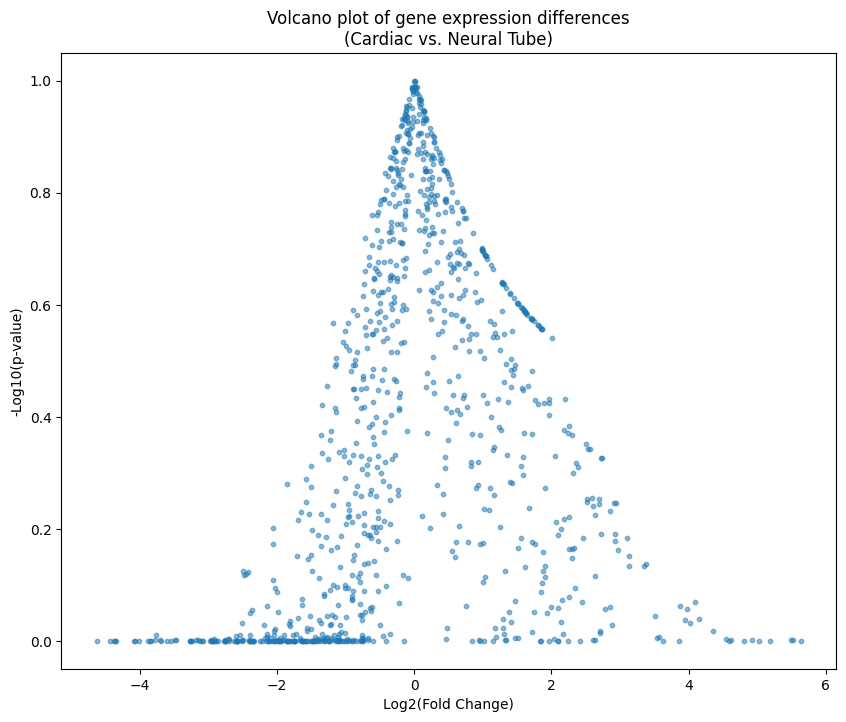

In [44]:
fc = np.log2(cardiac_means / neural_means)


fig, ax = plt.subplots(figsize=(10, 8))
# Plot all genes
ax.scatter(fc, p_values, s=10, alpha=0.5)

# Label plot
ax.set_xlabel("Log2(Fold Change)")
ax.set_ylabel("p-value")
ax.set_title("Volcano plot of gene expression differences\n(Cardiac vs. Neural Tube)")

# Show plot
plt.show()

/var/folders/sg/4dp480wd1cjd288xvby34rpr0000gn/T/ipykernel_73427/3534409374.py:5: RuntimeWarning: divide by zero encountered in log10
  ax.scatter(fc, -np.log10(p_values), s=10, alpha=0.5)


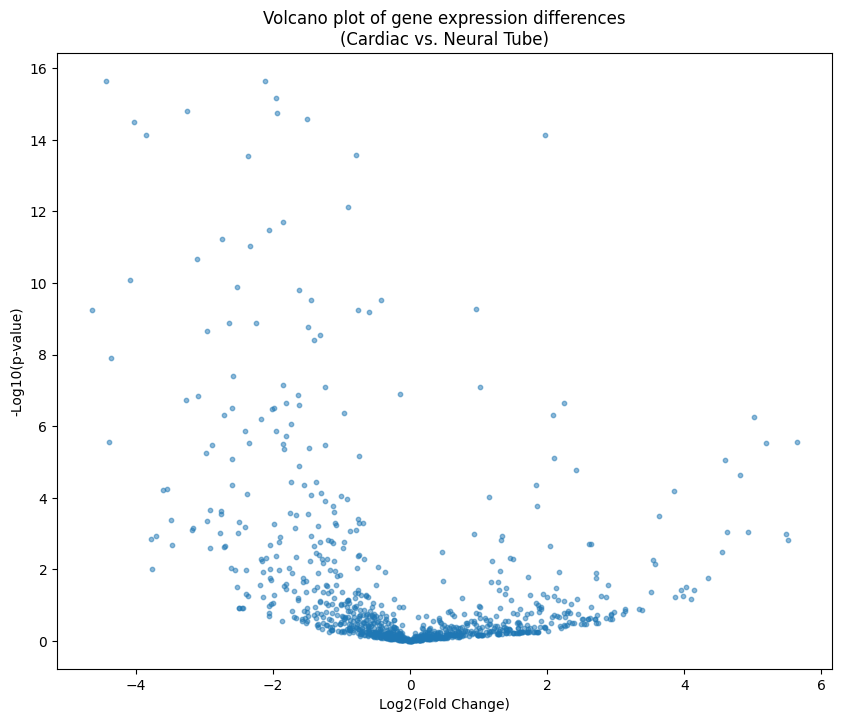

In [45]:
fc = np.log2(cardiac_means / neural_means)
fig, ax = plt.subplots(figsize=(10, 8))

# Plot all genes
ax.scatter(fc, -np.log10(p_values), s=10, alpha=0.5)

# Label plot
ax.set_xlabel("Log2(Fold Change)")
ax.set_ylabel("-Log10(p-value)")
ax.set_title("Volcano plot of gene expression differences\n(Cardiac vs. Neural Tube)")

# Show plot
plt.show()

### **e) Use the Mann-Whitney (non-parametric) $U$-test to find $p$-values for genes with significantly different expression between the two cell types. Report the percent of significant genes from this test that overlap with those from the $t$-test in c) (both after Bonferroni correction). (5 points)**

The Mann-Whitney $U$ test is a non-parametric test, which uses the $U$ statistic (as opposed to the $t$ statistic) to essentially count how many pairs of observations between $X^g_1$ and $X^g_2$ have one value greater than, equal to, and less than the other. This tests for whether the probability that a value from $X^g_1$ exceeds a value in $X^g_2$ is the same as the probability that a value from $X^g_2$ exceeds a value in $X^g_1$ i.e. $H_0: P(X^g_1 > X^g_2) = P(X^g_2 > X^g_1)$ and $H_1: P(X^g_1 > X^g_2) ≠ P(X^g_2 > X^g_1)$. Under the null hypothesis, the distribution of $U$ is normal. 

You can use the scipy package directly for this test, [scipy Mann-Whitney U](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html), which will calculate both the $U$ value and $p$-value for the two sets of observations you input.

In [113]:
import scipy
mann_p = np.zeros_like(p_values)
i = 0
for x1, x2 in zip(cardiac_counts.T, neural_counts.T):
    _, mann_p[i] = scipy.stats.mannwhitneyu(x1, x2)
    i += 1

In [114]:
mann_sig_genes = mann_p < a_bon
old_sig_genes = p_values < a_bon
overlap_genes = np.sum(np.logical_and(mann_sig_genes, old_sig_genes))
overlap_percent = overlap_genes / np.sum(mann_sig_genes) * 100
print(f"overlap percent: {overlap_percent}%")

overlap percent: 47.08520179372198%


### **f) Make a volcano plot for your results in e) ($U$ test, comparison between cell types 'Cardiac' and 'Neural Tube'). Select a gene you believe has a significant $p$-value and substantial fold change (FC).** 
###**Report the (1) $p$-value and log2FC for the gene, (2) color this gene on your volcano plot, and (3) briefly describe the function of this gene.  (5 points)**

Selected gene: Col3a1
P-value: 2.06507536909337e-07
Log2 Fold Change: -4.38538


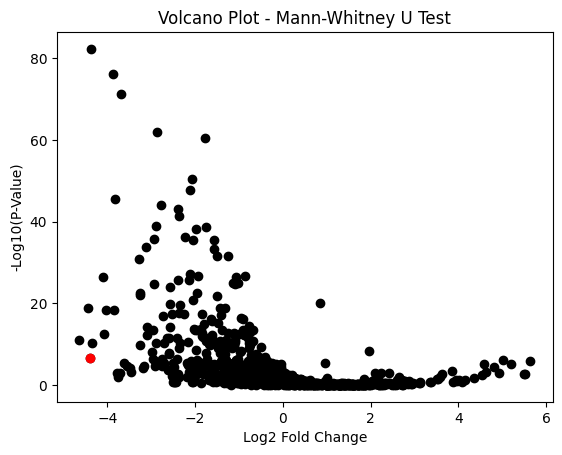

In [118]:
log2_fc = np.log2(cardiac_means / neural_means)

plt.scatter(log2_fc, -np.log10(mann_p), color='black')
plt.xlabel("Log2 Fold Change")
plt.ylabel("-Log10(P-Value)")
plt.title("Volcano Plot - Mann-Whitney U Test")

# Select a gene with significant p-value and substantial fold change
gene_idx = np.where(np.logical_and(mann_p < a_bon, np.abs(log2_fc) > 1))[0][0]
gene_name = np.array(meta_gene['gene_name'][np.logical_and(cardiac_vars != 0, neural_vars != 0)])[gene_idx]
log2fc = log2_fc[gene_idx]
pval = mann_p[gene_idx]

# Color selected gene on volcano plot
plt.scatter(log2fc, -np.log10(pval), color='red')

# Report results for selected gene
print(f"Selected gene: {gene_name}")
print(f"P-value: {pval}")
print(f"Log2 Fold Change: {log2fc:.5f}")

This gene is responsible for providing instructions for making type3 collagen.

### **g) As a negative control, randomly sample two groups of cells from cell type 'Cardiac' (each group the size of half of cell type 'Cardiac'). Perform a $t$-test as in a-b on all genes, treating the two groups as two cell types. Report the minimum $p$-value you obtain from this testing. (5 points)**
**Re-run the subsetting in a) to remove genes with zero variance in either of the two cell groups (from the set of already subsetted genes).*

In [149]:
half_size = len(cardiac_counts) // 2
idx_half = np.random.choice(len(cardiac_counts), size=half_size, replace=False)
idx_other = np.setdiff1d(np.arange(len(cardiac_counts)), idx_half)

group_1 = cardiac_counts[idx_half]
group_2 = cardiac_counts[idx_other]

means_g1 = np.mean(group_1, axis=0)
means_g2 = np.mean(group_2, axis=0)
vars_g1 = np.var(group_1, axis=0)
vars_g2 = np.var(group_2, axis=0)

n1 = len(group_1)
n2 = len(group_2)

stds = np.sqrt(((n1-1) * vars_g1 + (n2-1) * vars_g2) / (n1 + n2 - 2))
t_values = (means_g1 - means_g2) / (stds * np.sqrt(1/n1 + 1/n2))

In [150]:
p_values = 2 * (1 - t.cdf(np.abs(t_values), n1+n2-2))

In [151]:
print(f"minimum p_value in negative sample: {np.nanmin(p_values)}")

minimum p_value in negative sample: 0.0036295812072231204
